# Knockoffs vs. pseudo-variables

The purpose of this notebook is to show why knockoffs work, as opposed to permutations and other dummy pseudo-variables.

In [1]:
library(tidyverse)
library(SNPknock)
set.seed(2018)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Generate the data

In this example, we will generate 1000 observations of the explanatory variables from a hidden Markov model.
The parameters of the model are stored in the "data" subdirectory and they were obtained by running `fastPHASE` on the first 1000 reference SNPs from the International HapMap Project. 

In [2]:
# Load the hidden Markov model parameters
hmm <- readRDS("data/hmm.rds")

In [3]:
# Sample X
X = SNPknock.models.sampleHMM(hmm$pInit, hmm$Q, hmm$pEmit, n=1000)
X[1:5,1:10]

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,] 0    1    2    1    1    0    1    1    0    0    
[2,] 0    1    1    1    0    0    1    2    0    0    
[3,] 1    1    2    1    1    0    1    0    1    0    
[4,] 1    1    2    1    2    0    1    0    0    0    
[5,] 0    1    0    1    0    0    1    2    0    0

In [4]:
# Generate the knockoffs
Xk = SNPknock.knockoffHMM(X, hmm$pInit, hmm$Q, hmm$pEmit)
Xk[1:5,1:10]

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,] 0    1    2    1    1    0    1    1    0    0    
[2,] 0    1    1    1    0    0    1    2    0    1    
[3,] 1    2    2    0    1    0    1    0    0    0    
[4,] 1    1    2    1    2    0    1    1    0    0    
[5,] 0    1    1    1    0    0    1    2    0    0

The response variables are generated from a linear model with 60 nonzero coefficients. 

In [5]:
# Define the distribution of Y|X
amplitude <- 15
nonzero <- sample(ncol(X), 60)
beta <- (2*rbinom(ncol(X),1,0.5)-1) * amplitude * (1:ncol(X) %in% nonzero) / sqrt(nrow(X))
y.sample <- function(x) {
  x %*% beta + rnorm(nrow(x))
}
# Sample Y|X
y <- y.sample(X)

## Knockoffs as negative controls

We now compute importance measures for each of the 1000 variables, by applying ridge regression to the augmented matrix $(X,\tilde{X})$.

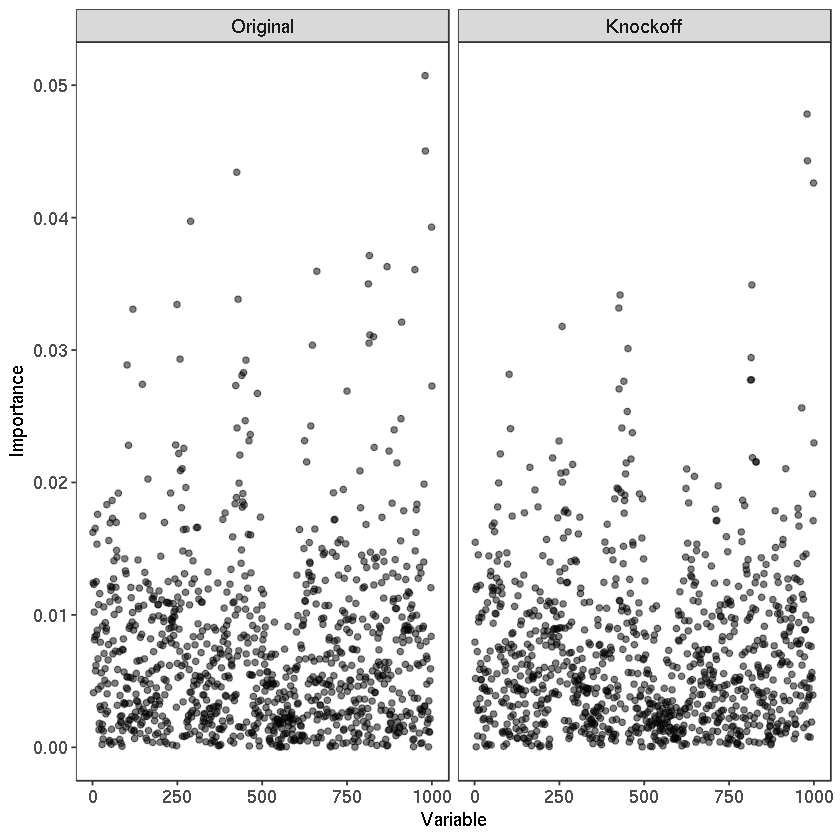

In [6]:
# Center and scale the augmented data matrix; then fit ridge regression
model.knock <- glmnet::cv.glmnet(scale(cbind(X,Xk)),y,alpha=0)

# Only draw the importance measures for the unimportant (null) variables
colors <- rep("black", ncol(X))
colors[nonzero] <- "white"

# Plot the importance measures
Importance.knock <- tibble(Variable=rep(1:ncol(X), 2), 
                          Importance=abs(coef(model.knock, s="lambda.min")[-1]), 
                          Color=c(colors,rep("black", ncol(X))), 
                          Knockoff=rep(c("Original","Knockoff"), each=ncol(X)))
plt.knock <- Importance.knock %>% 
    mutate(Knockoff = factor(Knockoff, levels=c("Original","Knockoff"), labels=c("Original","Knockoff"))) %>%
    mutate(Color == "black") %>%
    ggplot(aes(x=Variable, y=Importance)) + 
    geom_point(alpha=0.5) + 
    facet_wrap(Knockoff ~ .) +
    theme_bw() +        
    theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
         axis.title=element_text(size=11),
         panel.grid.major = element_blank(), panel.grid.minor = element_blank())

ggsave("figures/importance_knockoffs.pdf", plt.knock, width = 16, height = 8, units = "cm")
plt.knock

Knockoffs are perfect negative-control variables!

## Permutations instead of knockoffs

What if we used permutations instead of knockoffs?

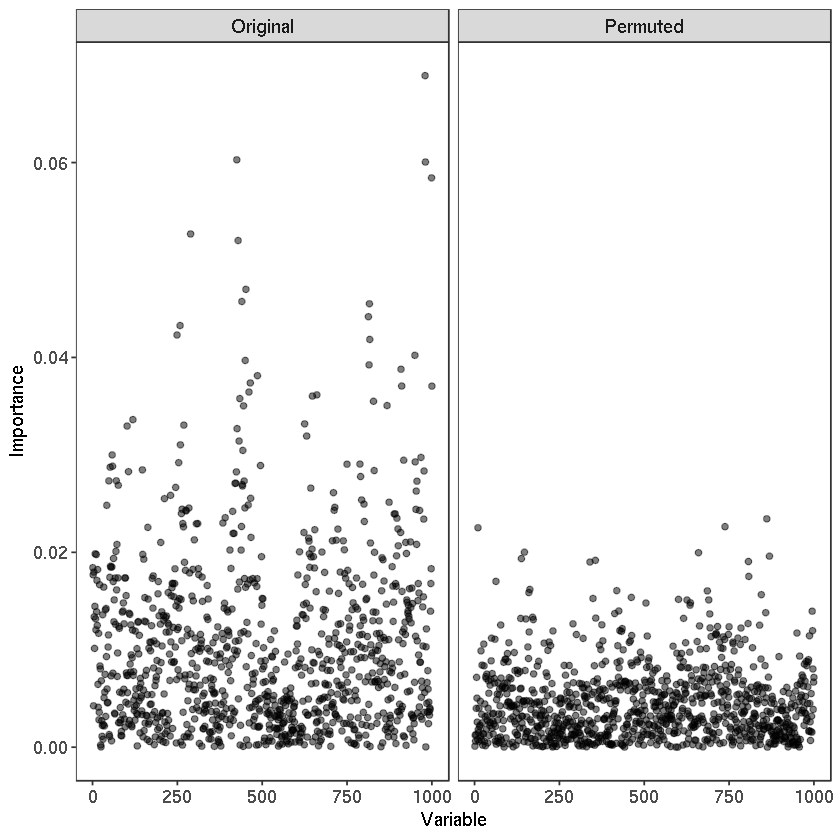

In [7]:
# Permute the original variables
X0 <- X[sample(nrow(X),nrow(X),replace=F),]

# Center and scale the augmented data matrix; then fit ridge regression
model.perm <- glmnet::cv.glmnet(scale(cbind(X,X0)),y,alpha=0)

# Plot the importance measures
Importance.perm <- tibble(Index=rep(1:ncol(X), 2), 
                          Importance=abs(coef(model.perm, s="lambda.min")[-1]), 
                          Color=c(colors,rep("black", ncol(X))), 
                          Knockoff=rep(c("Original","Knockoff"), each=ncol(X)))
plt.perm <- Importance.perm %>% 
    mutate(Knockoff = factor(Knockoff, levels=c("Original","Knockoff"), labels=c("Original","Permuted"))) %>%
    mutate(Color == "black") %>%
    mutate(Variable=Index) %>%
    ggplot(aes(x=Variable, y=Importance)) + 
    geom_point(alpha=0.5) + 
    facet_wrap(Knockoff ~ .) +
    theme_bw() +
    theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
         axis.title=element_text(size=11),
         panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave("figures/importance_permutations.pdf", plt.perm, width = 16, height = 8, units = "cm")
plt.perm

Permutations do not produce good negative-control variables!

## Dummy pseudo-variables instead of knockoffs

What if we used independent pseudo-variables instead of knockoffs?

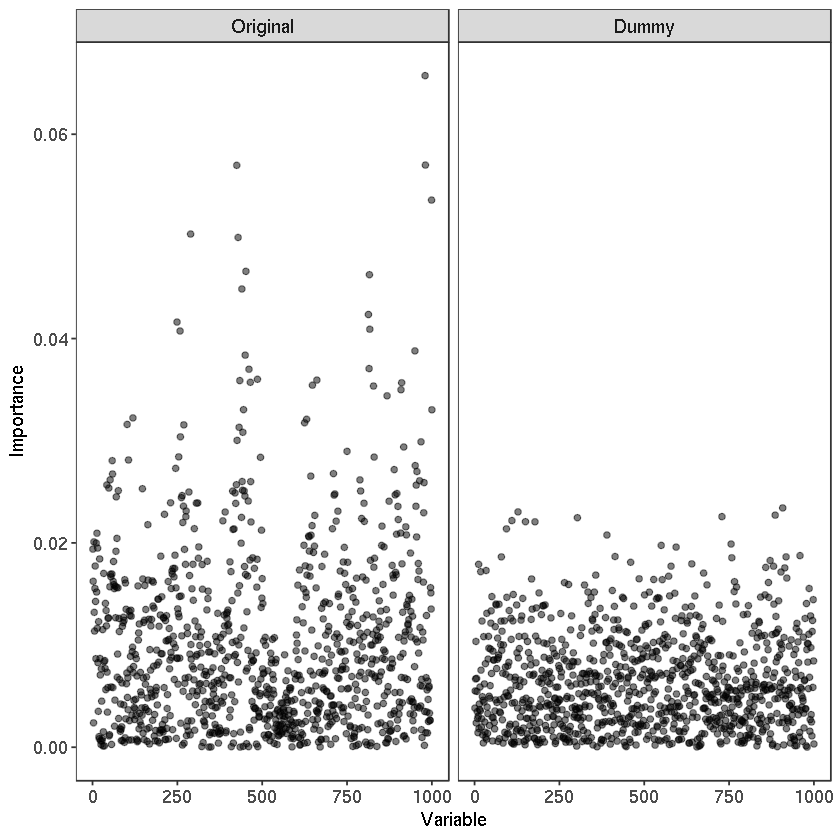

In [8]:
# Generate dummy pseudo variables distributed as white noise
Xd <- matrix(rnorm(nrow(X)*ncol(X)),nrow(X),ncol(X))

# Center and scale the augmented data matrix; then fit ridge regression
model.dummy <- glmnet::cv.glmnet(scale(cbind(X,Xd)),y,alpha=0)

# Plot the importance measures
Importance.dummy <- tibble(Index=rep(1:ncol(X), 2), 
                          Importance=abs(coef(model.dummy, s="lambda.min")[-1]), 
                          Color=c(colors,rep("black", ncol(X))), 
                          Knockoff=rep(c("Original","Knockoff"), each=ncol(X)))
plt.dummy <- Importance.dummy %>% 
    mutate(Knockoff = factor(Knockoff, levels=c("Original","Knockoff"), labels=c("Original","Dummy"))) %>%
    mutate(Color == "black") %>%
    mutate(Variable=Index) %>%
    ggplot(aes(x=Variable, y=Importance)) + 
    geom_point(alpha=0.5) + 
    facet_wrap(Knockoff ~ .) +
    theme_bw() +
    theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
         axis.title=element_text(size=11),
         panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave("figures/importance_dummy.pdf", plt.dummy, width = 16, height = 8, units = "cm")
plt.dummy

Dummy pseudo-variables are not good negative-controls!